# Data Processing for Movement Classification

## Setup

In [1]:
# import libraries
import os
import glob
import bz2
import pickle

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from numpy.lib.stride_tricks import sliding_window_view
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder

%matplotlib inline

## Getting the Dataset

The files contain the data in two parts: Smartwatch Data Readings, and movement labels. We first construct a function to read the content of .pbz2 files.


In [2]:
# construct a function to read .pbz2 files
def read_pbz2(path):
    """
    Read a .pbz2 file from the file path

    Parameters:
    path (str): The path of the file to read

    Returns:
    tuple (meta data, smartwatch data): A tuple of meta data and smartwatch readings
    """

    with bz2.BZ2File(path, 'rb') as f:
        data = f.read()
    decomp_data = pickle.loads(data)

    return decomp_data

There are some empty .csv files in the directory that contain no data.

In [3]:
# helper function to get a list of empty .csv files
def get_empty_csv(directory):
    """
    Create a list of empty csv files (to avoid errors during importing)

    Parameters:
    directory (str): The path of the directory containing the files

    Returns:
    list ([file_1, file_2, ...]):
    A list containing names of csv files that are empty
    """

    empty_files = []
    csv_files = glob.glob(os.path.join(directory, '*.csv'))

    for file_name in csv_files:
        try:
            pd.read_csv(file_name)
        except:
            empty_files.append(file_name)

    return empty_files

In [4]:
# helper function to organize the files based on experiment
def get_files_dict(directory):
    """
    Help function for importing all files in a directory
    in an organized manner

    Parameters:
    directory (str): The path of the directory containing the files

    Returns:
    dict ({file_key: [.pbz2, .csv1, ...]}):
    A dictionary containing the files in the directory grouped by their ID
    """

    pbz2_files = glob.glob(os.path.join(directory, '*.pbz2'))
    csv_files = glob.glob(os.path.join(directory, '*.csv'))
    empty_files = get_empty_csv(directory)
    file_dict = {}

    for file_name in pbz2_files:
        file_name_short = os.path.basename(file_name)
        k = os.path.splitext(file_name_short)[0]
        file_dict[k] = [file_name]

    # we use the empty .csv list to exempt the empty files from the dictionary
    for file_name in csv_files:
        if file_name not in empty_files:
            file_name_short = os.path.basename(file_name)
            k = file_name_short.split('_')[0]
            if k in file_dict:
                file_dict[k].append(file_name)
            else:
                file_dict[k] = [file_name]

    return file_dict

In [5]:
file_dict = get_files_dict('/project/data/')
print('5c91085923feb407ddeb5e1c', file_dict['5c91085923feb407ddeb5e1c'])

5c91085923feb407ddeb5e1c ['/project/data/5c91085923feb407ddeb5e1c.pbz2', '/project/data/5c91085923feb407ddeb5e1c_0_KH2018_movements.csv', '/project/data/5c91085923feb407ddeb5e1c_1_KH2018_movements_seq.csv']


The files are organized into multiple experiments (readings) where different children executed various movements and their readings were recorded. In addition to the readings and meta data, we have files with movements labels.

After organizing the files together in a dictionary, we need a helper function to merge the two dataframes on time index creating labeled readings.

In [6]:
# helper function to merge two dataframes (readings and labels) on time
def merge_dfs(df_1, df_2):
    """
    Merge smartwatch data on timestamp with movements data on time

    Parameters:
    df_1 (DataFrame): Dataframe containing smartwatch data
    df_2 (DataFrame): Dataframe containing movement data

    Returns:
    DataFrame: Dataframe containing movement labeled smartwatch data
    """

    ts = float(df_2.Comments[0].split(' ')[1])
    # changing the data readings to match the frequency of the labels
    df_2['t'] = df_2.Time.apply(lambda x: x + ts)
    df_2 = df_2.drop(['Time', 'Comments', 'Handedness'], axis=1)                ## not sure whether to remove Handedness or not
    end = df_2.t.max()
    df_merged = pd.merge_ordered(df_1, df_2, on='t', fill_method='ffill')
    df_merged = df_merged[df_merged.t <= end]
    # replacing nan values with no_movement label
    df_merged['Movement'] = df_merged.loc[:, 'Movement'].replace(np.nan, 'no_movement')
    # replacing incorrect value (Glas_grabbing)
    df_merged['Movement'] = df_merged.loc[:, 'Movement'].replace('Glas_grabbing', 'Glass_grabbing')
    # replacing incorrect value (Glas_grabbing)
    df_merged.dropna(axis=0, how='any', inplace=True)
    # setting the timeseries index
    df_merged.set_index('t', inplace=True)

    return df_merged

In [7]:
df_1 = read_pbz2('/project/data/5c91085923feb407ddeb5e1c.pbz2')[1]
df_2 = pd.read_csv('/project/data/5c91085923feb407ddeb5e1c_0_KH2018_movements.csv')
df_exp = merge_dfs(df_1, df_2)
df_exp.head()

,uacc_x,uacc_y,uacc_z,gyr_x,gyr_y,gyr_z,grav_x,grav_y,grav_z,att_w,att_x,att_y,att_z,Movement
t,,,,,,,,,,,,,,
1.553001e+09,0.029788,0.021187,-0.003950,-0.102073,-0.183036,-0.024474,-0.071765,-0.373192,-0.924974,0.981040,0.190448,-0.035248,0.006843,no_movement
1.553001e+09,0.036850,0.025760,-0.012893,0.068435,-0.239833,-0.038702,-0.075348,-0.372867,-0.924820,0.981006,0.190276,-0.037213,0.006138,no_movement
1.553001e+09,0.029177,-0.006785,0.002810,0.163142,-0.237258,-0.060632,-0.079378,-0.375234,-0.923525,0.980681,0.191525,-0.039442,0.005266,no_movement
1.553001e+09,-0.005181,-0.031485,0.028754,0.122949,-0.195905,-0.065495,-0.082924,-0.378198,-0.922003,0.980297,0.193082,-0.041444,0.004323,no_movement
1.553001e+09,-0.023226,-0.036402,0.028817,-0.003729,-0.077282,-0.040135,-0.085020,-0.379323,-0.921350,0.980134,0.193663,-0.042657,0.003615,no_movement


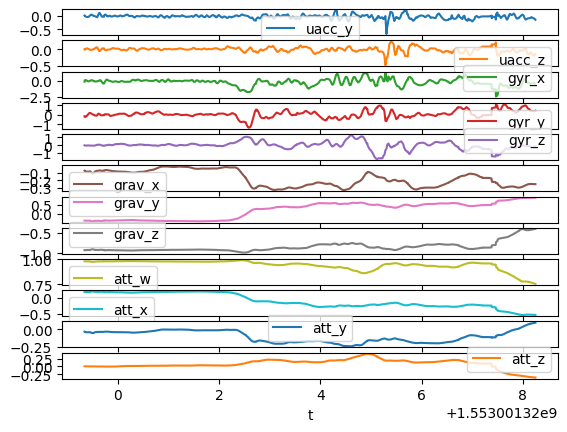

In [8]:
# explore the frequencies of the features of the data
plot_features = df_exp.iloc[:500, 1:-1]
plot_features.index = df_exp.index[:500]
_ = plot_features.plot(subplots=True)

In [9]:
df_exp.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
uacc_x,30222.0,0.191749,0.805496,-7.766358,-0.079826,0.025527,0.306226,15.373652
uacc_y,30222.0,0.065903,0.690108,-10.066143,-0.174020,0.019165,0.283259,16.014387
uacc_z,30222.0,0.078779,0.696497,-15.581813,-0.146428,0.001266,0.281421,9.766805
gyr_x,30222.0,0.016798,3.205841,-30.724142,-1.025510,0.015192,1.237012,23.634851
gyr_y,30222.0,0.098120,2.011890,-15.719363,-0.636944,0.039375,0.850360,17.694574
gyr_z,30222.0,0.012152,2.620284,-17.784435,-0.839250,0.019353,0.852141,24.157465
grav_x,30222.0,0.680258,0.445466,-0.999816,0.592010,0.894319,0.960862,0.999998
grav_y,30222.0,0.217243,0.394411,-0.999754,0.023260,0.223318,0.463118,0.999741
grav_z,30222.0,-0.192394,0.314729,-0.999652,-0.371066,-0.152849,0.024632,0.979021
att_w,30222.0,0.135927,0.599820,-0.997781,-0.511052,0.369148,0.654838,0.992748


In [10]:
df_exp.Movement.value_counts()

no_movement    22195
Hopscotch       1786
Frog            1024
Seal             744
Swimming         739
Goliath          697
Rabbit           696
Dwarf            684
Bear             559
Spider           506
Crab             380
Lame_fox         212
Name: Movement, dtype: int64

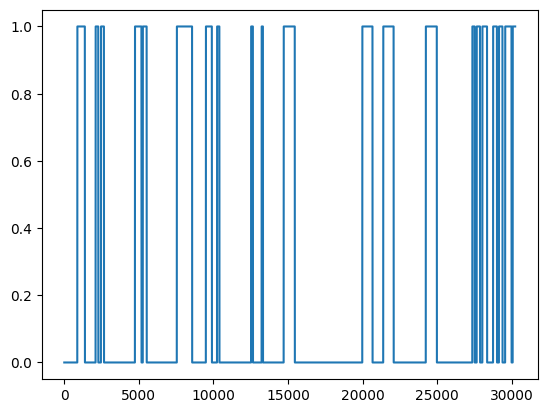

In [11]:
# plotting the frequency of movement
movement = np.where(df_exp.Movement != 'no_movement', 1, 0)
plt.plot(movement)
plt.show()

### Splitting the Data

We divide the children into three groups of train, validation and test with 50%, 25% and 25% respectively. To do this we choose random samples from the IDs of the children to make sure the data is independent, and not randomly shuffled.

In [12]:
# helper function to select child ids for train, validation, and test groups
def separate_ids(ids):
    """
    Split the children in the experiment between train, validation, and test groups.

    Parameters:
    ids (list): A list of children IDs

    Returns:
    tuple(lists): A tuple of lists containing IDs for three groups
    """

    # set the seed
    np.random.seed(42)
    # change the list to a unique one
    ids_unique = list(set(ids))
    # sample the validation and test IDs
    valid_test = np.random.choice(ids_unique, size=20, replace=False)
    # restructure the training IDs
    train = [id for id in ids_unique if id not in valid_test]
    # sample the test IDs from the valid_test
    test = np.random.choice(valid_test, size=10, replace=False)
    # restructure the valid IDs
    valid = [v for v in valid_test if v not in test]

    return train, valid, test

### Standardization and Storing Data

In [15]:
def get_dfs_lists():
    """
    Concatenate all smartwatch data with their labels to create one dataset

    Returns:
    DataFrame: Dataframe containing all experiments (smartwatch data + labels)
    """

    # specify the directory and get the file_dict
    directory = '/project/data/'
    file_dict = get_files_dict(directory)

    # initialize data and ids
    data = []
    ids = []

    train_data = []
    valid_data = []
    test_data = []

    train_features = []
    valid_features = []
    test_features = []

    train_labels = []
    valid_labels = []
    test_labels = []

    # loop over the experiments
    for experiment in file_dict.keys():
        # if there's only 1 file skip (no movements labels)
        if len(file_dict[experiment]) == 1:
            continue
        # if there are 2 or more files, merge the dataframes to get labeled data
        else:
            meta_data = read_pbz2(file_dict[experiment][0])[0]
            animal_name = meta_data['animal']['animalName']

            # only select the data for normally developed children
            df_1 = read_pbz2(file_dict[experiment][0])[1]
            df_2 = pd.read_csv(file_dict[experiment][1])
            df_exp = merge_dfs(df_1, df_2)
            df_exp.reset_index(drop=True, inplace=True)
            id = animal_name

            # check if the data is not empty before appending to the list
            if len(df_exp) != 0:
                data.append(df_exp)
                ids.append(id)

    train_id, valid_id, test_id = separate_ids(ids)

    # loop over the list of ids and append each dataframe to its relevant list
    for idx, id in enumerate(ids):
        # check if the dataframe is not empty
        if id in train_id and len(data[idx]) !=0:
            train_data.append(data[idx])
        elif id in valid_id and len(data[idx]) !=0:
            valid_data.append(data[idx])
        elif id in test_id and len(data[idx]) !=0:
            test_data.append(data[idx])

    # standardize the data
    # first get the mean and standard deviation by dataframe in train data list
    train_means = [train_df.mean(numeric_only=True) for train_df in train_data]
    train_stds = [train_df.std(numeric_only=True) for train_df in train_data]
    # aggregate the mean and standard deviation
    train_mean = np.mean(train_means, axis=0)
    train_std = np.mean(train_stds, axis=0)

    # transforming train, valid, test data
    for train_df in train_data:
        y_train = train_df['Movement'].values
        x_train = train_df.drop('Movement', axis=1)
        x_train = (x_train - train_mean) / train_std

        train_features.append(x_train)
        train_labels.append(y_train)


    for valid_df in valid_data:
        y_valid = valid_df['Movement'].values
        x_valid = valid_df.drop('Movement', axis=1)
        x_valid = (x_valid - train_mean) / train_std

        valid_features.append(x_valid)
        valid_labels.append(y_valid)

    for test_df in test_data:
        y_test = test_df['Movement'].values
        x_test = test_df.drop('Movement', axis=1)
        x_test = (x_test - train_mean) / train_std

        test_features.append(x_test)
        test_labels.append(y_test)



    return (train_features, valid_features, test_features,
            train_labels, valid_labels, test_labels)

In [16]:
train_features, valid_features, test_features, train_labels, valid_labels, test_labels = get_dfs_lists()

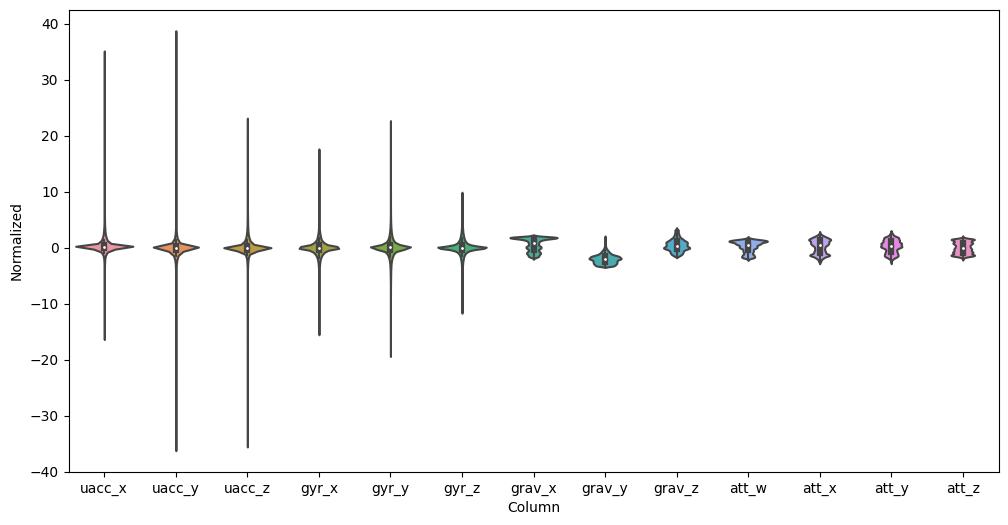

In [17]:
df_std = train_features[0]
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
plt.show()

### Data Windowing

In order for the models to work on the time series classification problems we need to first window the data of each experiment. After that, we can generate our final data sets by stacking the arrays together.

In [18]:
# construct a function to generate windowed data
def generate_window(x, y, window_length, stride):
    """
    Generate windows of X, and y arrays for time series classification

    Parameters:
    x (2d numpy array): Two dimensional numpy array with axis 0 as the readings
                        and axis 1 as the variables
    y (1d numpy array): One dimensional numpy array with labels
    window_length (int): Integer specifying the length of the instances
    stride (int): Integer specifying the overlap (step jump)

    Returns:
    tuple (3d numpy array, 1d numpy array): A tuple of numpy arrays; the first
            with shape (instances, variables, steps) and
            the second specifying the labels using the most frequent value over the time steps
    """
    ## sliding a window of specific length and stride over a 2d numpy array
    x = sliding_window_view(x, window_length, 0)[::stride, :, :]

    ## encode y before applying sliding window in order for mode to work
    le = LabelEncoder()
    y = le.fit_transform(y)

    ## sliding a window of specific length, stride getting the most frequent value
    y = sliding_window_view(y, window_length, 0)[::stride, :]
    # get the mode over the time steps
    y = mode(y, axis=1, keepdims=False)[0]

    # transform the data back to the original labels
    y = le.inverse_transform(y)

    return x, y

In [19]:
def get_data(sub):
    """
    Generate the final data sets to use for the ML development

    Parameters:
    sub (str): String defining whether to return train, valid or test data

    Returns:
    tuple (3d numpy array, 1d numpy array): Tuple of feature, and target arrays
    """
    # retrieve the data lists
    train_features, valid_features, test_features, train_labels, valid_labels, test_labels = get_dfs_lists()

    # new lists to hold the windowed data
    X = []
    Y = []

    # specify the window length and stride
    window_length = 100
    stride = 50

    # decide which sets to return
    if sub == 'train':
        # loop over the specific list
        for x, y in zip(train_features, train_labels):
            x, y = generate_window(x, y, window_length, stride)
            X.append(x)
            Y.append(y)

    elif sub == 'valid':
        for x, y in zip(valid_features, valid_labels):
            x, y = generate_window(x, y, window_length, stride)
            X.append(x)
            Y.append(y)

    elif sub == 'test':
        for x, y in zip(test_features, test_labels):
            x, y = generate_window(x, y, window_length, stride)
            X.append(x)
            Y.append(y)

    # stack the lists X, Y
    X = np.vstack(X)
    Y = np.hstack(Y)

    return X, Y

In [ ]:
X_train, y_train = get_data('train')

In [ ]:
X_valid, y_valid = get_data('valid')

In [ ]:
X_test, y_test = get_data('test')

In [ ]:
X_train.shape, y_train.shape

In [ ]:
X_valid.shape, y_valid.shape

In [ ]:
X_test.shape, y_valid.shape

## Saving the Data

We save the data in a single .npz file for ease of access and importing when training and testing models.

In [ ]:
np.savez_compressed('/project/data.npz',
                    X_train=X_train, X_valid=X_valid, X_test=X_test,
                    y_train=y_train, y_valid=y_valid, y_test=y_test)

In [ ]:
del X_train, X_valid, X_test, y_train, y_valid, y_test

In [ ]:
with np.load('/project/data.npz', allow_pickle=True) as data:
    X_train = data['X_train']
    X_valid = data['X_valid']
    X_test = data['X_test']
    y_train = data['y_train']
    y_valid = data['y_valid']
    y_test = data['y_test']

In [ ]:
X_train.shape, y_train.shape

In [ ]:
X_valid.shape, y_valid.shape

In [ ]:
X_test.shape, y_test.shape